In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
#as_frame=False returns nd.array, otherwise it will return pd.dataframe (default)
mnist.keys()
#there are 784 pixels (28*28 images)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
mnist["data"][:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [3]:
mnist["target"][:5] #targets are the labels

array(['5', '0', '4', '1', '9'], dtype=object)

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
type(X)
#when indexing pd.dataframe, use .loc[n]

numpy.ndarray

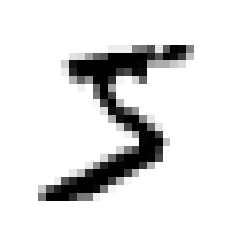

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_img = some_digit.reshape(28,28)

plt.imshow(some_digit_img, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
import numpy as np
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
#the set provided is already shuffled and split into training/test sets
#this prevents missing digits from sets (due to it being shuffled)
#and prevents many instances of digits in a row (same)

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
#stochastic gradient descent (SGD)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()#random_state=False for reproducible results, however it relies on randomness
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [13]:
print(y[11])
sgd_clf.predict([X[11]]) #can predict

5


array([ True])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9629, 0.9613, 0.9536])

In [28]:
from sklearn.base import BaseEstimator

def Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)#returns the predictions made

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
#top row: non 5s (roughly 53k guesses correct)
#top right: incorrect guesses (in this case assumed to be 5)
#NOT TARGET[RIGHT, WRONG]
# IS TARGET[WRONG, RIGHT]
#bottom row: is 5s (roughly 4k guesses correct)

array([[53472,  1107],
       [ 1453,  3968]])

In [40]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)
#this is an example of a perfect set of predictions

array([[54579,     0],
       [    0,  5421]])

In [45]:
#precision formula
#(TP) / (TP + FP)
#TP: true positives
#FP: false positives
5421 / (5421 + 1453) #precision for the confusion matrix above (predictions)

0.7886237998254292

In [48]:
#recall formula
#(TP) / (TP + FN)
5421 / (5421 + 1107) #for the predictions confusion matrix above

0.8304227941176471

In [51]:
#confusion matrix is as follows

#[TN, FP]
#[FN, TP]

In [52]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.781871921182266

In [54]:
recall_score(y_train_5, y_train_pred)

0.7319682715366168

In [57]:
#f1 score
#combined precision and recall scores
#it is the harmonic mean of the precision and recall
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
#the f1 score favours when precision and recall are similar

#you cannot have both precision and recall
#increase in 1 will decrease the other
#depending on the situation, one may be greatly preferred than the other

0.7560975609756098

In [61]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3801.68656666])

In [65]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [67]:
#to find which threshold to use
#cross validate

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
#the method tells it to return the decision scores instead of the predictions
y_scores

array([  -675.48018863, -21032.35672048, -25696.01706177, ...,
         9689.9901406 ,  -6055.3702007 , -11540.82731202])

In [68]:
y_scores

array([  -675.48018863, -21032.35672048, -25696.01706177, ...,
         9689.9901406 ,  -6055.3702007 , -11540.82731202])

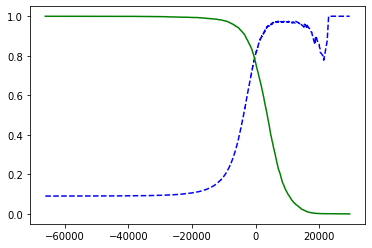

In [71]:
#use precision recall curve to compute precision and recall for all possible threshold

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [74]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision #to find the threshold that gives 90% precision

1957.9115454430075

In [77]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90
type(y_train_pred_90)

numpy.ndarray

In [78]:
precision_score(y_train_5, y_train_pred_90)

0.9001048767697954

In [79]:
recall_score(y_train_5, y_train_pred_90)

0.6332779929902232

In [80]:
#ROC - receiver operating characteristic
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

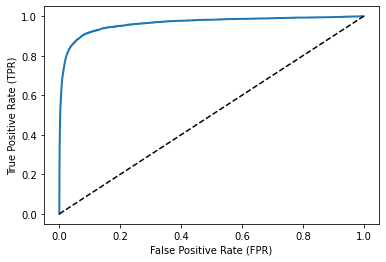

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, )
    plt.plot([0,1],[0,1],'k--')#dashed diagonal line
    
plot_roc_curve(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()
#shows that the higher the recall (TPR)
#the more false positives (FPR)

#the dotted line representsROC curve of purely random classifier
#good classifier should aim as far away from it as possible (top left)

In [91]:
#measure the Area Under Curve (AUC)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)
#perfect classifier will have a score of 1
#random classifier will have a score of 0.5

0.9634891767781838

In [92]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [94]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

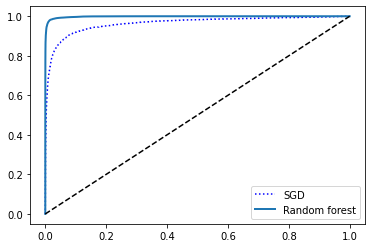

In [102]:
#plot the ROC curve

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random forest")
plt.legend(loc="lower right")
plt.show()
#this shows that the random forest classifier is superior
#to the  SGD classifier because
#its ROC curve is closer to the top left (greater Area Under Curve AUC)

In [103]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [106]:
#Support Vector Machine classifier
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #not y_train_5
svm_clf.predict([some_digit])
#the code trains the SVC using the original target classes (0-9) len:10
#behind the scenes it is doing OvO (one vs one)
#which means it trained 45 binary classifiers
#got their decision scores
#then chose the highest scoring class
#(that is why it takes so long)

array([5], dtype=uint8)

In [107]:
some_digit_scores = svm_clf_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [108]:
np.argmax(some_digit_scores)

5

In [109]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [113]:
#np.argmax(some_digit_scores)
#returns class value which is the same index as
#the highest scoring decision_function
#in this case it is index 5, value 5
svm_clf.classes_[5]

5

In [114]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [116]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [117]:
len(ovr_clf.estimators_)

10

In [122]:
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

In [125]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
#SGD classifiers can directly classify instances into multiple classes
#so OvO or OvR was not necessary

array([5], dtype=uint8)

In [126]:
sgd_clf.decision_function([some_digit])
#class 3 and 5 are very similar in this case

array([[-22373.64808903, -52839.01385032, -10612.58346802,
          6292.06417165, -21576.63105988,   6418.91575225,
        -19425.24027337, -18105.17410471,  -6590.04992041,
         -9446.89327549]])

In [127]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
#the result is above 87% each time
#random classifier would get about 10%

array([0.8761, 0.8747, 0.8761])

In [128]:
#to increase accuracy even more, it is worth scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9031 , 0.89325, 0.9057 ])

In [129]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5585,    0,   21,    7,    8,   49,   37,    6,  209,    1],
       [   0, 6410,   38,   26,    4,   44,    4,    8,  195,   13],
       [  27,   26, 5254,   99,   72,   26,   68,   36,  340,   10],
       [  23,   17,  118, 5259,    2,  206,   27,   42,  364,   73],
       [  12,   15,   48,   10, 5203,   12,   38,   26,  306,  172],
       [  26,   16,   31,  170,   53, 4498,   76,   15,  473,   63],
       [  31,   15,   41,    3,   41,   97, 5565,    3,  121,    1],
       [  19,   10,   52,   31,   49,   14,    3, 5701,  164,  222],
       [  17,   67,   46,   91,    3,  126,   25,   10, 5418,   48],
       [  23,   20,   29,   65,  119,   38,    1,  177,  327, 5150]])

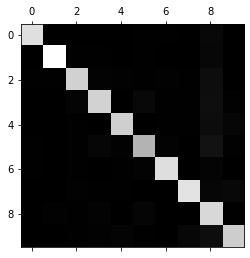

In [130]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
#the result is pretty good
#since most images are on the main diagonal
#5 is slightly darker than the rest
#this may be because there were fewer 5s in the dataset
#or because the classifier performs worse on the 5

In [131]:
#divide each value in the confusion matrix
#by the number of images of the corresponding class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

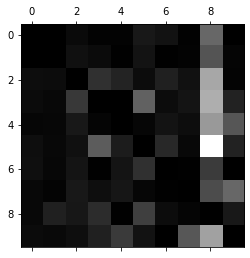

In [133]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#the column for 8 is bright
#which indicates that many numbers get incorrectly classified as 8
#while the row for 8 is dark, meaning 8 gets correctly classified

#the goal could be to reduce the amount of wrong 8 predictions
#possibly by increasing the number of images of numbers that look like 8
#(but are not)